Following a conversation with [@alimanfoo](www.twitter.com/alimanfoo), we thought it would be neat to animate the genetic signature of a population crash/expansion as it unfolds.

Although a forward simulation is probably more appropriate here, I chose the blisteringly fast coalesent simulator `msprime`. Strictly speaking, the simulations shown here aren't following a single population crashing, but multiple independent populations at different time periods given a particular demographic history.

`msprime` is plenty fast enough to handle this type of work, comfortably handling 140 separate coalescent simulations over 10 Mbp. Also, the independent observations allow us to visualise the inherent stochasticity present.

The rest of the post details how this was done. But the final animation is shown just below...

The site frequency spectrum (SFS) is the distribution of allele frequencies, this encodes information regarding population demographic history. Populations that have experienced contraction tend to have a dearth of rare variants. Here we plot the scaled SFS, where a stable population is expected to show a straight (horizontal) line. Tajima's D is a related statistic, and represents the ratio of variation at a per chromosome level to the absolute number of variants in the population. 

Following the crash we see that even after 5000 generations, the site frequency spectrum is far from a horizontal line. Also, Tajima's D is heavily right skewed. This is an interesting observation - severe population bottlenecks still leave a signature 5000 generations later!

This is explored a little more thoroughly at the bottom of this page.

In [1]:
#HTML(html5)

In [2]:
from IPython.display import HTML

In [3]:
from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os
import numpy as np
import msprime
import math
import allel

## Simulations begin

If you happened to see my previous post, I wrote about the interface between `msprime` and `scikit-allel`, see [here](http://hardingnj.github.io/2017/08/23/power-of-correct-tools.html). This function is taken directly from that, but with one addition, a cache for previously generated tree sequences. Although `msprime` is fast, simulating 140 different dempgraphic scenarios takes some time!

In [5]:
def growth_dem_model(pop_cfg, dem_hist, length=1e7, mu=3.5e-9, rrate=1e-8, seed=None, 
                     verbose=False, string=None):

    fn = os.path.join("/tmp", string + ".h5")
    
    if os.path.isfile(fn):
        tree_sequence = msprime.load(fn)
        if verbose:
            print("Loaded tree sequence from file.")
    else:
        # call to msprime simulate method. This returns a generator of tree sequences. 
        # One gotcha I found is that the object returned is different if you use the num_replicates argument
        tree_sequence = msprime.simulate(
            length=length, recombination_rate=rrate,
            mutation_rate=mu, random_seed=seed,
            population_configurations=pop_cfg,
            demographic_events=dem_hist)

        tree_sequence.dump(fn)
    
    # print the number of mutations in the trees using an internal method
    if verbose:
        print("Simulated ", tree_sequence.get_num_mutations(), "mutations")
    
    # thanks to Jerome for the code here.
    # The best way to do this is to preallocate a numpy array 
    # (or even better the allel.HaplotypeArray), and fill it incrementally: 
    V = np.zeros((tree_sequence.get_num_mutations(), tree_sequence.get_sample_size()),
                 dtype=np.int8)

    for variant in tree_sequence.variants():
        V[variant.index] = variant.genotypes 
    
    # create a haplotype array in allel from numpy arrays of 0s/1s
    # as the dataset is reasonably small there is no need to use the chunking functionality of allel
    gt = allel.HaplotypeArray(V)
    
    # scikit-allel expects integer values here rather than infinite sites model of msprime.
    pos = allel.SortedIndex([int(variant.position) for variant in tree_sequence.variants()])
    
    return gt, pos

### Parameters

Here I define recombination rate, mutation rate, and how much DNA I want to simulate!

In [6]:
rrate = 1e-8
mu = 1e-8

window_size = 10000 #bp
contig_size = 10000000 #bp
sample_size = 100 # chromosomes

### Specifications

Here I make some intial specifications about the demographic history I wish to simulate... The population is at time `t` 1000 chromosomes, with a decline of 0.5% per generation for 1000 generations completing at 5000 generations in the past.

In [7]:
initial_size = 1000
span = 1000
gen_limit = 7000
growth_rate = -0.005
abs_time = 5000

Now we need to decide which generations to simualate, I chose a gap of 100 generations, but reduced to 10 during the population crash. This has the nice effect of having more detail over this time point, as well as slowing down the animation during the interesting bit.

In [8]:
# define the generations to iterate over.
# more time on interesting periods.
generations = np.concatenate(
    [np.arange(0, abs_time, 100),
     np.arange(abs_time, abs_time + span, 10), 
     np.arange(abs_time + span, gen_limit, 100)])
generations

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000, 5010, 5020, 5030, 5040,
       5050, 5060, 5070, 5080, 5090, 5100, 5110, 5120, 5130, 5140, 5150,
       5160, 5170, 5180, 5190, 5200, 5210, 5220, 5230, 5240, 5250, 5260,
       5270, 5280, 5290, 5300, 5310, 5320, 5330, 5340, 5350, 5360, 5370,
       5380, 5390, 5400, 5410, 5420, 5430, 5440, 5450, 5460, 5470, 5480,
       5490, 5500, 5510, 5520, 5530, 5540, 5550, 5560, 5570, 5580, 5590,
       5600, 5610, 5620, 5630, 5640, 5650, 5660, 5670, 5680, 5690, 5700,
       5710, 5720, 5730, 5740, 5750, 5760, 5770, 5780, 5790, 5800, 5810,
       5820, 5830, 5840, 5850, 5860, 5870, 5880, 5890, 5900, 5910, 5920,
       5930, 5940, 5950, 5960, 5970, 5980, 5990, 60

In [9]:
len(generations)

160

This is just a quick sum to work out the ancestral size of the population- because we are dealing with the coalescent, we work backwards...

In [10]:
# ancestral size
initial_size * math.exp(-growth_rate * span)

148413.1591025766

In [11]:
size_history = []

Here I specify a seed so that the cacheing described above works.

In [12]:
np.random.seed(42)
seeding = np.random.randint(0, 10000, len(generations))

The crash truly happens at 5000 gen - 6000 generations ago. However, we need to adjust the times that are read into `msprime`, as everything has to be relative. ie at t=1000, then the crash is 4000 generations away, not 5000.

After the simulation we are only interested in the allele counts, so we keep those in a dict.

In [13]:
# we need to recalculate the pop history each loop, as the relative time to crash changes...
ac = {}

for gen, seed in zip(generations, seeding):
    
    rel_time = abs_time - gen
    
    # if the crash has not yet occurred. Then fixed pop size
    if (gen > (abs_time + span)):
        history_p = None
            
    else:
        stability = msprime.PopulationParametersChange(
            time=rel_time + span, growth_rate=0, population_id=0)

        crash = msprime.PopulationParametersChange(
                    time=max(rel_time, 0), growth_rate=growth_rate, population_id=0)

        history_p = [crash, stability]
            
    # now work out the size of the population at this time.
    
    # if rel time is positive... then 0.
    if rel_time > 0:
        g_of_crash = 0
    else:
        g_of_crash = min(-rel_time, span)
    
    size_t = initial_size * math.exp(-growth_rate * g_of_crash)
    size_history.append(size_t)
    
    pop_config = [msprime.PopulationConfiguration(
        sample_size=sample_size, initial_size=size_t, growth_rate=0)]
    
    identifier = "sim_s{0}_g{1}".format(seed, gen)
    
    # now simulate
    haps, pos = growth_dem_model(pop_config, history_p, length=contig_size, mu=mu, rrate=rrate, 
                                 seed=int(seed), string=identifier)

    
    # we are only really interested in allele frequencies...
    ac[gen] = pos, haps.count_alleles()

Using `scikit-allel` we calculate the scaled site frequency spectrum and Tajima's D in 10kbp windows. These are stored in dicts to be used later in the animation.

In [14]:
tajima = {}
sfs = {}
for gen, (pos, allele_counts) in ac.items():
    
    tjd, _, _ = allel.diversity.windowed_tajima_d(
        pos, allele_counts, size=window_size, start=0, stop=contig_size)
    
    sfs_scaled = allel.sfs_scaled(allele_counts[:, 1])
    
    tajima[gen] = tjd
    sfs[gen] = sfs_scaled

In [15]:
from functools import reduce

In [16]:
# this value used to decide where the y limit is!
max_var = reduce(max, [max(x) for x in sfs.values()])

## Now animate

In [17]:
n_frames = len(generations)
n_frames

160

In [18]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

This is a fairly standard matplotlib animation. It's not the most efficient, as it redraws the whole axes for the SFS and Tajima's D plots, but it does the job.

These two tutorials helped me immensely:
http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/

https://stackoverflow.com/questions/43552575/how-to-make-a-matplotlib-animated-violinplot


In [19]:
# First set up the figure, the axis, and the plot element we want to animate
fig, axes = plt.subplots(ncols=3, figsize=(11, 4))

for ax in axes:
    sns.despine(ax=ax, offset=5)

# ax0
ax1, ax2, ax3 = axes
ax1.plot(generations, [val*1e-3 for val in size_history])
ax1.set_ylabel(r"Ne x $10^{3}$")
ax1.set_xlabel("generations")

line1, = ax1.plot([], [])

shapes = [line1]

# initialization function: plot the background of each frame
def init():
    shapes[0].set_data([], [])
    return shapes

# animation function.  This is called sequentially
def animate(i):
    # i is the frame number (to n_gen)
    
    gen = generations[::-1][i]
    tjd = tajima[gen] 
    sfs_scaled = sfs[gen]
    
    tjd = np.compress(~np.isnan(tjd), tjd)
    
    # animate line
    shapes[0].set_data((gen, gen), (0, size_history[-1]))
    
    # animate second
    ax2.clear()
    
    sns.despine(ax=ax2, offset=5)
    ax2.set_ylim((0, max_var * 1e-3 * 0.75))
    allel.plot_sfs_scaled(sfs_scaled * 1e-3, ax=ax2)
    ax2.set_ylabel(r"scaled site freq. x $10^3$")
    
    # third
    ax3.clear()
    sns.despine(ax=ax3, offset=5)
    ax3.set_ylabel("density")
    ax3.set_xlabel(r"Tajima's $D$")
    ax3.set_ylim((0, 1.2))
    ax3.set_xlim((-5, 7))
    
    ax3.vlines([0.0], 0, 1.2, linestyle="--", color="k", lw=1.0)
    sns.distplot(a=tjd, ax=ax3)
    
    return shapes

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frames, interval=200, blit=True)

In [20]:
plt.close()

In [21]:
html5 = anim.to_html5_video()
HTML(html5)

In [22]:
anim.save("../assets/popcrash.mp4")

## Is a crash detectable 5000 generations later?

To investivate this I ran two contrasting demographic scenarios. One a population that has been at a constant Ne of 1000 for 5000 generations, but before that experiencing a severe crash from approximately 140,000 over a span of 1000 generations. 

The null, alternative model shows a population at a stable Ne of 1000.

The simulation below clearly shows an extremely disrupted site frequency spectrum in the "crash model".

In [23]:
history_pA = [
    msprime.PopulationParametersChange(time=5000, growth_rate=growth_rate, population_id=0),
    msprime.PopulationParametersChange(time=6000, growth_rate=0, population_id=0)]

history_pB = []


pop_config = [msprime.PopulationConfiguration(
    sample_size=sample_size, initial_size=1000, growth_rate=0)]

seed = 1001
idenA = "5kcrash"
idenB = "nocrash"

# now simulate
hapsA, posA = growth_dem_model(pop_config, history_pA, length=contig_size, mu=mu, rrate=rrate,
                               seed=int(seed), string=idenA)


# now simulate
hapsB, posB = growth_dem_model(pop_config, history_pB, length=contig_size, mu=mu, rrate=rrate,
                               seed=int(seed), string=idenB)

# we are only really interested in allele frequencies...
sfs_a = allel.stats.sfs_scaled(hapsA.count_alleles()[:, 1])
sfs_b = allel.stats.sfs_scaled(hapsB.count_alleles()[:, 1])

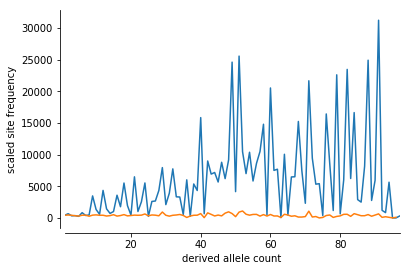

In [24]:
fig, ax = plt.subplots()
sns.despine(ax=ax, offset=5)
allel.plot_sfs_scaled(sfs_a, ax=ax)
allel.plot_sfs_scaled(sfs_b, ax=ax)
plt.show()